In [41]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire_r', 2)


%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import KNNImputer
# Baza danych gównych do nauki modelu
train = pd.read_csv("train.csv") 
# Baza danych Titanica do sprawdzenia modelu
test = pd.read_csv("test.csv")

In [42]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [43]:
print(train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


# Czyszczenie i przygotowanie danych

In [44]:
print(pd.isnull(train).sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [45]:
print(pd.isnull(test).sum())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


#### Przygotwanie kolumny 'Cabin' do encodowania

In [46]:
def extract_cabin_details(cabin):
  try:
    parts = cabin.split('/')
    if len(parts) == 2:
      cabin_type, deck_level = parts
      section_number = None
    elif len(parts) == 3:
      cabin_type, deck_level, section_number = parts
    else:
      raise ValueError("Nieprawidłowy format wartości w kolumnie Cabin")
    return cabin_type, int(deck_level), section_number
  except ValueError:
    return None, None, None

for df in [train, test]:
  df['Cabin_Filled'] = df['Cabin'].notna()

  # Ekstrakcja parametrów
  df.loc[df['Cabin_Filled'], 'Cabin_Type'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[0]
  df.loc[df['Cabin_Filled'], 'Cabin_Deck'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[1]
  df.loc[df['Cabin_Filled'], 'Cabin_Section'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[2]

  # Uzupełnianie wartości NaN
  df['Cabin_Type'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Deck'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Section'].replace('NaN', np.nan, inplace=True)

  # Konwersja typów
  df['Cabin_Deck'] = df['Cabin_Deck'].astype('float')
  df['Cabin_Type'] = df['Cabin_Type'].astype('category')
  df['Cabin_Section'] = df['Cabin_Section'].astype('category')

  # Usunięcie kolumny pomocniczej
  del df['Cabin_Filled']

#### Przygotwanie kolumny Name do zastępienia jej kolumną rodzina

In [47]:
for df in [train, test]:
  # Create Last_Name column, handling missing values
  df['Last_Name'] = df['Name'].str.split().str[-1].fillna(pd.NA)

In [48]:
def find_groups(df):
    groups = {}
    for name, group in df.groupby('Last_Name'):
        for cabin, subgroup in group.groupby('Cabin'):
            if len(subgroup) > 1:
                if subgroup['Family'].all():
                    subgroup['Family'] = 1
                groups[name] = list(subgroup.index)

    return groups

# Zastosowanie funkcji do DataFrame'ów test i train
for df in [test, train]:
    df['Family'] = 0
    groups = find_groups(df.copy())
    for name, group in groups.items():
        df.loc[group, 'Family'] = 1
train['Family'].value_counts()

Family
0    6513
1    2180
Name: count, dtype: int64

### Ordinal encoding

In [49]:
enc = OrdinalEncoder()
Enc_col = ['HomePlanet', 'CryoSleep', 'Destination' , 'VIP', 'Cabin_Type', 'Cabin_Section' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: HomePlanet
  Wartość zakodowana: 0 -> Wartość początkowa: Earth
  Wartość zakodowana: 1 -> Wartość początkowa: Europa
  Wartość zakodowana: 2 -> Wartość początkowa: Mars
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: CryoSleep
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Destination
  Wartość zakodowana: 0 -> Wartość początkowa: 55 Cancri e
  Wartość zakodowana: 1 -> Wartość początkowa: PSO J318.5-22
  Wartość zakodowana: 2 -> Wartość początkowa: TRAPPIST-1e
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: VIP
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Cabin_Type
  Wartość zakodowana: 0 -> Wartość początkowa: A
  Wartość zakodowana: 1 -> Wartość początkowa: B
  Wartość zakodowana: 2 -> Wartość początkowa: C
  Wartoś

In [50]:
categorical_features = ['PassengerId','HomePlanet', 'CryoSleep', 'Cabin', 'Destination' , 'Name', 'VIP', 'Cabin_Type', 'Last_Name',  'Cabin_Section']
for df in [train, test]:
     df.drop(columns=categorical_features, inplace=True)
print(pd.isnull(train).sum())

Age                  179
RoomService          181
FoodCourt            183
ShoppingMall         208
Spa                  183
VRDeck               188
Transported            0
Cabin_Deck           199
Family                 0
HomePlanet_Enc       201
CryoSleep_Enc        217
Destination_Enc      182
VIP_Enc              203
Cabin_Type_Enc       199
Cabin_Section_Enc    199
dtype: int64


Text(0.5, 1.05, 'Macierz korelacji Perasona')

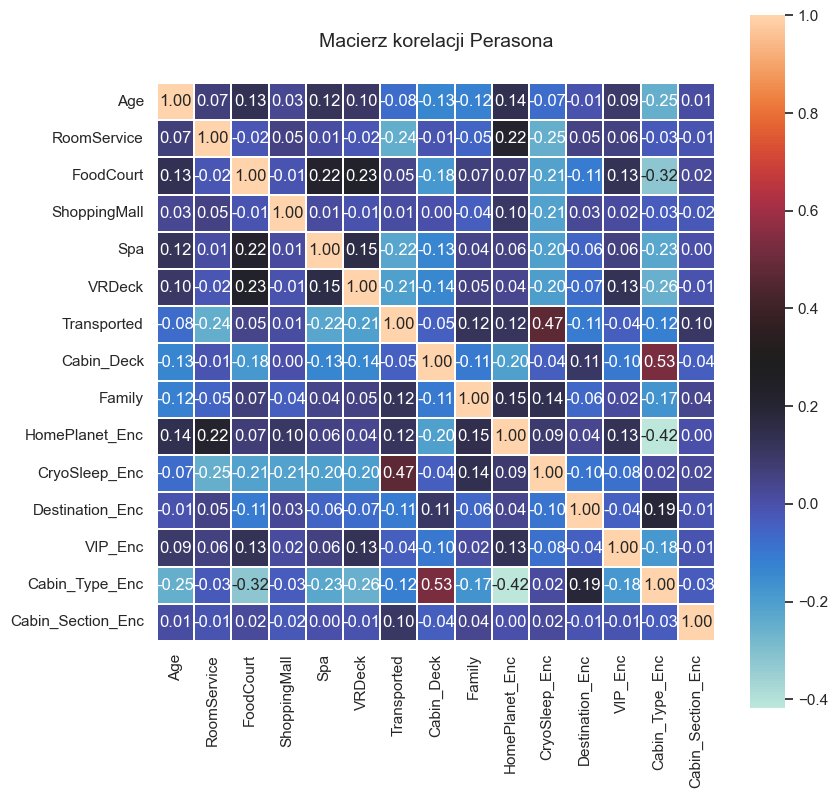

In [51]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05,   size=14)

In [52]:
train.groupby('Transported').mean().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc
Transported,,,,,,,,,,,,,,
False,29.92,389.27,382.62,167.57,564.38,543.63,623.62,0.2,0.57,0.13,1.57,0.03,4.51,0.45
True,27.75,63.10,532.69,179.83,61.68,69.15,577.45,0.3,0.76,0.58,1.39,0.02,4.10,0.56


In [53]:
#Biblioteki
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics         import make_scorer, f1_score, accuracy_score

from sklearn.neural_network  import MLPClassifier

from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingClassifier

from sklearn.naive_bayes     import GaussianNB

from sklearn.svm             import NuSVC

from sklearn.neighbors       import KNeighborsClassifier

from catboost                import CatBoostClassifier

In [54]:
#Baza danych
X_train = train.drop('Transported',axis=1)
y_train = train['Transported']

X_test = test
y_test = []

In [55]:
#Modele które zostaną wykorzystane
classifiers = [['Random Forest',RandomForestClassifier()],
               ['AdaBoost',AdaBoostClassifier()],
               ['Gradient Boosting',GradientBoostingClassifier()],
               ['Nu Support Vector Machine', NuSVC()], 
               ['HGBC',HistGradientBoostingClassifier()], 
               ['Naive Bayes',GaussianNB()],
               ['Cat', CatBoostClassifier(verbose=False)],
              ]

In [56]:
## Wstępna ocena wydajności modeli z domyślnymi parametrami
import warnings
warnings.simplefilter('ignore')

for metric in ['accuracy','f1']:
    SKfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
    score_mean = []
    std = []
    
    for model in classifiers:
        clf = model[1]
        cv_result = cross_val_score(clf,X_train, y_train, cv = SKfold, scoring = metric)
        cv_result = cv_result
        score_mean.append(cv_result.mean())
        std.append(cv_result.std())
        
    models_evaluation = pd.DataFrame({metric: score_mean}, index=[i[0] for i in classifiers])
    print(models_evaluation.sort_values(metric, ascending=False))
    print('*'*32)

ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 133, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1049, in check_array
    _assert_all_finite(
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
AdaBoostClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
